In [1]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"arixyt","key":"e649a7bc7401e4d8354650d6f006dcb0"}'}

In [2]:
import os
os.makedirs('~/.kaggle', exist_ok=True)
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot create regular file '/root/.kaggle/': Not a directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [3]:
!kaggle datasets download -d tawsifurrahman/tuberculosis-tb-chest-xray-dataset


Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/tuberculosis-tb-chest-xray-dataset
License(s): copyright-authors
100% 662M/663M [00:34<00:00, 21.9MB/s]
100% 663M/663M [00:34<00:00, 20.0MB/s]


In [4]:
!unzip tuberculosis-tb-chest-xray-dataset.zip -d /content/tb_xray_dataset/

Archive:  tuberculosis-tb-chest-xray-dataset.zip
  inflating: /content/tb_xray_dataset/TB_Chest_Radiography_Database/Normal.metadata.xlsx  
  inflating: /content/tb_xray_dataset/TB_Chest_Radiography_Database/Normal/Normal-1.png  
  inflating: /content/tb_xray_dataset/TB_Chest_Radiography_Database/Normal/Normal-10.png  
  inflating: /content/tb_xray_dataset/TB_Chest_Radiography_Database/Normal/Normal-100.png  
  inflating: /content/tb_xray_dataset/TB_Chest_Radiography_Database/Normal/Normal-1000.png  
  inflating: /content/tb_xray_dataset/TB_Chest_Radiography_Database/Normal/Normal-1001.png  
  inflating: /content/tb_xray_dataset/TB_Chest_Radiography_Database/Normal/Normal-1002.png  
  inflating: /content/tb_xray_dataset/TB_Chest_Radiography_Database/Normal/Normal-1003.png  
  inflating: /content/tb_xray_dataset/TB_Chest_Radiography_Database/Normal/Normal-1004.png  
  inflating: /content/tb_xray_dataset/TB_Chest_Radiography_Database/Normal/Normal-1005.png  
  inflating: /content/tb_xray

In [5]:
import os
dataset_dir = '/content/tb_xray_dataset/TB_Chest_Radiography_Database'
os.listdir(dataset_dir)

['README.md.txt',
 'Tuberculosis.metadata.xlsx',
 'Normal.metadata.xlsx',
 'Tuberculosis',
 'Normal']

In [6]:
# Create train, val, and test directories
!mkdir -p /content/tb_xray_dataset/TB_Chest_Radiography_Database/train/normal
!mkdir -p /content/tb_xray_dataset/TB_Chest_Radiography_Database/train/tuberculosis
!mkdir -p /content/tb_xray_dataset/TB_Chest_Radiography_Database/val/normal
!mkdir -p /content/tb_xray_dataset/TB_Chest_Radiography_Database/val/tuberculosis
!mkdir -p /content/tb_xray_dataset/TB_Chest_Radiography_Database/test/normal
!mkdir -p /content/tb_xray_dataset/TB_Chest_Radiography_Database/test/tuberculosis

In [7]:
!pip install split-folders

In [8]:
import splitfolders  # To install: pip install split-folders

# Path to the dataset folder containing 'normal' and 'tuberculosis' images
input_folder = '/content/tb_xray_dataset/TB_Chest_Radiography_Database'

# Automatically create the split (80% training, 10% validation, 10% testing)
splitfolders.ratio(input_folder, output="/content/tb_xray_dataset",
                   seed=42, ratio=(.8, .1, .1), group_prefix=None)  # (.8, .1, .1) => 80% train, 10% val, 10% test

Copying files: 4200 files [00:02, 1945.33 files/s]


In [9]:
!rm -r /content/tb_xray_dataset/TB_Chest_Radiography_Database

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation and test data should only be rescaled
val_test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Load data from directories
train_generator = train_datagen.flow_from_directory(
    '/content/tb_xray_splits/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

validation_generator = val_test_datagen.flow_from_directory(
    '/content/tb_xray_splits/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    '/content/tb_xray_splits/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)


Found 3360 images belonging to 5 classes.
Found 420 images belonging to 5 classes.
Found 420 images belonging to 5 classes.


In [13]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Load the InceptionV3 model pre-trained on ImageNet
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully-connected layer and a logistic layer with 1 class (binary classification)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model (InceptionV3) to prevent them from being trained
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Show the model summary
model.summary()


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 111, 111, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 111, 111, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 111, 111, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 109, 109, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 109, 109, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 109, 109, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 109, 109, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 109, 109, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 109, 109, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 54, 54, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 54, 54, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 54, 54, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 54, 54, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 52, 52, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 52, 52, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 23,901,985 (91.18 MB)

 Trainable params: 2,099,201 (8.01 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [14]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


105/105 ━━━━━━━━━━━━━━━━━━━━ 92s 666ms/step - accuracy: 0.8759 - loss: 0.3279 - val_accuracy: 0.9351 - val_loss: 0.1537
Epoch 2/10


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0154
Epoch 3/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 121s 611ms/step - accuracy: 0.9463 - loss: 0.1445 - val_accuracy: 0.9351 - val_loss: 0.1461
Epoch 4/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0037
Epoch 5/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 69s 621ms/step - accuracy: 0.9580 - loss: 0.1186 - val_accuracy: 0.9399 - val_loss: 0.1213
Epoch 6/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0079
Epoch 7/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 82s 611ms/step - accuracy: 0.9656 - loss: 0.0944 - val_accuracy: 0.9471 - val_loss: 0.1339
Epoch 8/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0208
Epoch 9/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 81s 613ms/step - accuracy:

In [15]:
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print('Test accuracy:', test_acc)


13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 281ms/step - accuracy: 0.9735 - loss: 0.0735
Test accuracy: 0.9759615659713745


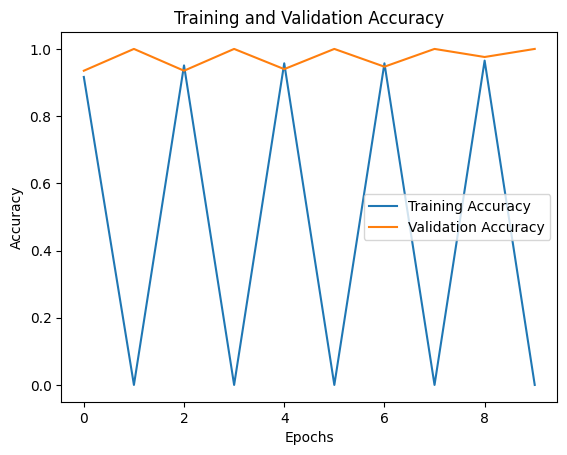

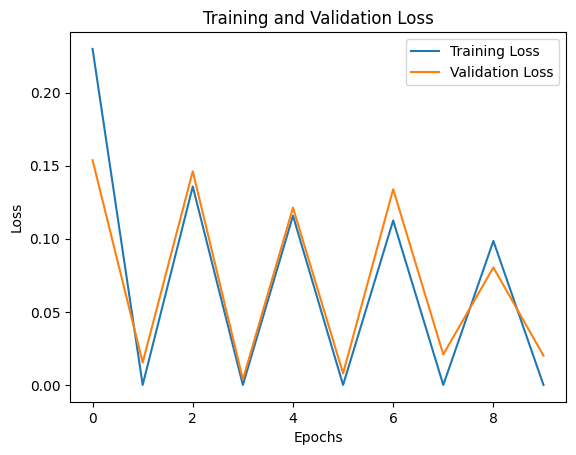

In [16]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
